In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
# Download Oxford 17 Category Flower Dataset
#!wget http://www.robots.ox.ac.uk/~vgg/data/flowers/17/17flowers.tgz -O 17flowers.tgz
#!tar -xvzf 17flowers.tgz

In [4]:
# Split the images in ./jpg into 17 folders
#!cd ./jpg && for i in {1..17}; do mkdir $i; done
# Move image_xxxx.jpg to folder (((xxxx-1)//80) + 1)
#!cd ./jpg && for i in {0001..1360}; do mv "image_$i.jpg" $(((i-1)/80 + 1)); done

In [5]:
# Build the VGG19 model
def get_model():
    model = torchvision.models.vgg19(weights="VGG19_Weights.IMAGENET1K_V1")

    classifiers = nn.Sequential(
        nn.Linear(25088, 4096),
        nn.ReLU(True),
        nn.Dropout(),
        nn.Linear(4096, 4096),
        nn.ReLU(True),
        nn.Dropout(),
        nn.Linear(4096, 17),
    )
    model.classifier = classifiers
    return model

In [6]:
# Build the transformer for the dataset in training, validation and testing
transformer = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Build the dataset in training, validation and testing from ./jpg where the images are stored in 17 folders
train_dataset = torchvision.datasets.ImageFolder(root='./jpg', transform=transformer)

# Split the dataset into training, validation and testing
train_size = int(0.8 * len(train_dataset))
val_size = int(0.1 * len(train_dataset))
test_size = len(train_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size, test_size])

In [7]:
# Set the batch size used for model training
batch_sizes =[4, 32, 64]

In [8]:
# Define the training function and return loss
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return loss.item()

# Define the validation function and return loss
def validate(model, device, valid_loader):
    model.eval()
    valid_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in valid_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            valid_loss += F.cross_entropy(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    valid_loss /= len(valid_loader.dataset)
    print('Validation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        valid_loss, correct, len(valid_loader.dataset),
        100. * correct / len(valid_loader.dataset)))
    return valid_loss

# Define the testing function and return accuracy
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return correct / len(test_loader.dataset)

In [9]:
# Define the optimizer
def get_optimizer(model, lr):
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    return optimizer

# Define the training process
def train_process(model, device, train_loader, valid_loader, optimizer, epochs, test_loader):
    train_loss = []
    valid_loss = []
    test_acc = []
    for epoch in range(1, epochs + 1):
        train_loss.append(train(model, device, train_loader, optimizer, epoch))
        valid_loss.append(validate(model, device, valid_loader))
        test_acc.append(test(model, device, test_loader))
    return train_loss, valid_loss, test_acc


In [10]:
# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [11]:
# Start training and testing
train_losses = []
valid_losses = []
test_accs = []
i = 0
for batch_size in batch_sizes:
    print('Batch size: {}'.format(batch_size))
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
    model = get_model()
    model = model.to(device)
    optimizer = get_optimizer(model, 0.001)
    train_loss, valid_loss, test_acc = train_process(model, device, train_loader, val_loader, optimizer, 60, test_loader)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    test_accs.append(test_acc)
    i += 1

Batch size: 4
Train Epoch: 1 [0/1088 (0%)]	Loss: 2.942848
Train Epoch: 1 [400/1088 (37%)]	Loss: 2.341105
Train Epoch: 1 [800/1088 (74%)]	Loss: 2.830624
Validation set: Average loss: 1.1618, Accuracy: 88/136 (65%)
Test set: Average loss: 1.2385, Accuracy: 81/136 (60%)
Train Epoch: 2 [0/1088 (0%)]	Loss: 0.201838
Train Epoch: 2 [400/1088 (37%)]	Loss: 2.106998
Train Epoch: 2 [800/1088 (74%)]	Loss: 3.700009
Validation set: Average loss: 2.2691, Accuracy: 80/136 (59%)
Test set: Average loss: 1.8198, Accuracy: 83/136 (61%)
Train Epoch: 3 [0/1088 (0%)]	Loss: 0.611753
Train Epoch: 3 [400/1088 (37%)]	Loss: 0.776656
Train Epoch: 3 [800/1088 (74%)]	Loss: 0.301801
Validation set: Average loss: 0.4263, Accuracy: 119/136 (88%)
Test set: Average loss: 0.4922, Accuracy: 116/136 (85%)
Train Epoch: 4 [0/1088 (0%)]	Loss: 0.076884
Train Epoch: 4 [400/1088 (37%)]	Loss: 0.499005
Train Epoch: 4 [800/1088 (74%)]	Loss: 0.028207
Validation set: Average loss: 0.7380, Accuracy: 108/136 (79%)
Test set: Average loss

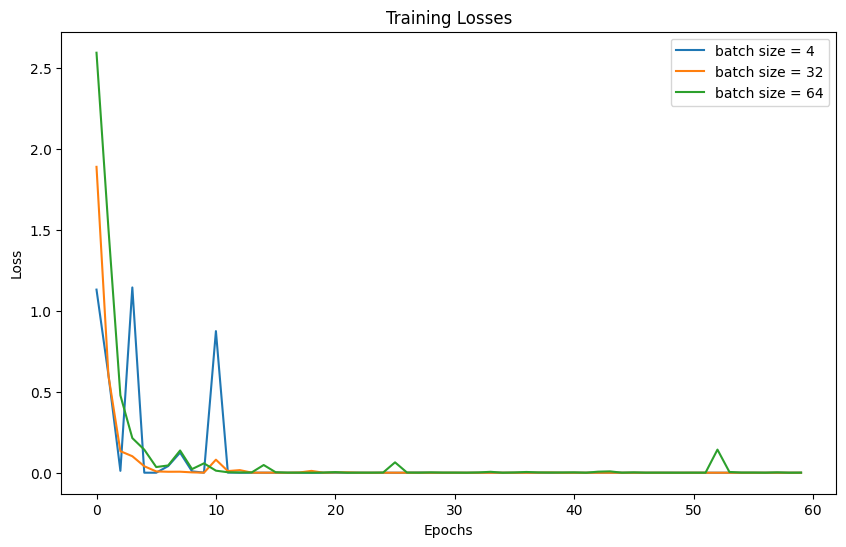

In [19]:
# Plot the training for different batch sizes
plt.figure(figsize=(10, 6))
for i in range(len(batch_sizes)):
    plt.plot(train_losses[i], label='batch size = {}'.format(batch_sizes[i]))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Losses')
plt.legend()

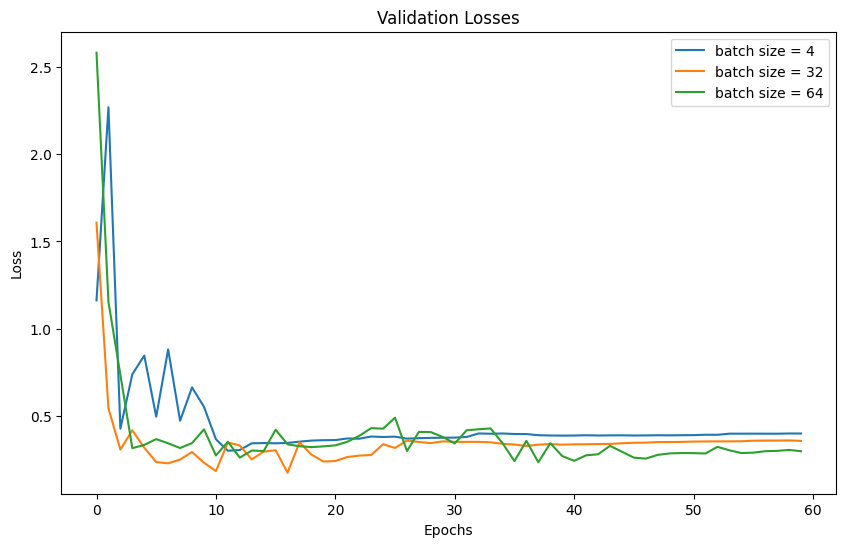

In [20]:
# Plot the validation for different batch sizes
plt.figure(figsize=(10, 6))
for i in range(len(batch_sizes)):
    plt.plot(valid_losses[i], label='batch size = {}'.format(batch_sizes[i]))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Losses')
plt.legend()

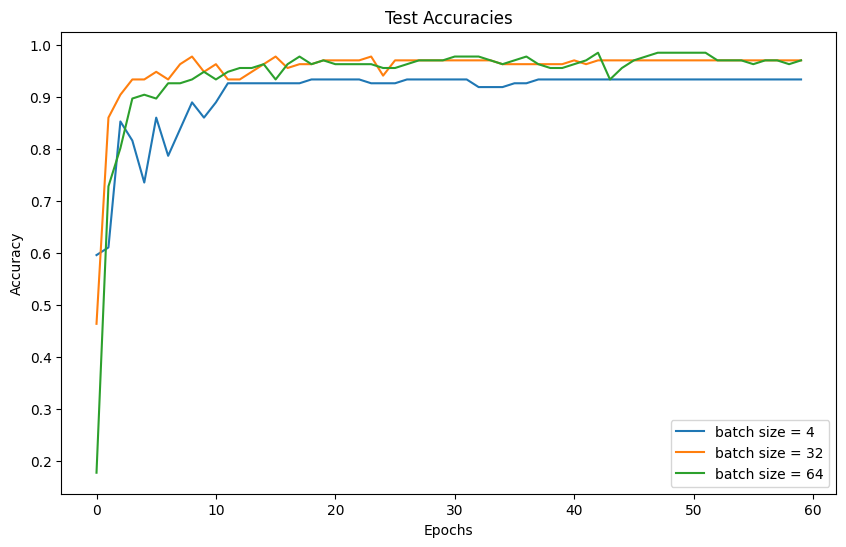

In [21]:
# Plot the test accuracy for different batch sizes
plt.figure(figsize=(10, 6))
for i in range(len(batch_sizes)):
    plt.plot(test_accs[i], label='batch size = {}'.format(batch_sizes[i]))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Test Accuracies')
plt.legend()

In [22]:
# Change the train_losses, valid_losses, test_losses, test_accs as different pandas dataframes
train_lossespd = pd.DataFrame({'batch_size_4': train_losses[0], 'batch_size_32': train_losses[1], 'batch_size_64': train_losses[2]})
valid_lossespd = pd.DataFrame({'batch_size_4': valid_losses[0], 'batch_size_32': valid_losses[1], 'batch_size_64': valid_losses[2]})
test_accspd = pd.DataFrame({'batch_size_4': test_accs[0], 'batch_size_32': test_accs[1], 'batch_size_64': test_accs[2]})

# Save the train_losses, valid_losses, test_losses, test_accs as csv files
train_lossespd.to_csv('./VGG19_result/train_losses.csv', index=False)
valid_lossespd.to_csv('./VGG19_result/valid_losses.csv', index=False)
test_accspd.to_csv('./VGG19_result/test_accs.csv', index=False)